In [1]:
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.algorithms.classifiers import QSVC

In [2]:
#===================================================================================================================================
import seaborn as sns
from openpyxl import Workbook, load_workbook
#===================================================================================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
#==================================================================================================================================
from imblearn.over_sampling import SMOTE
#===================================================================================================================================

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import os


In [3]:
def feature_selectionRFE(max_iter,data,X, y, numbers_features):
    std = StandardScaler()
    X = std.fit_transform(X)
    model = LogisticRegression(max_iter=max_iter)
    rfe = RFE(model,n_features_to_select=numbers_features)
    fit = rfe.fit(X,y)
    cols = fit.get_support(indices=True)
    features = data.iloc[:,cols]
    
    return features, cols

def feature_selectionKBest(X, y, numbers_features):
    std = StandardScaler()
    X = std.fit_transform(X)
    kbest = SelectKBest(score_func=f_classif, k=numbers_features)
    fit = kbest.fit(X,y)
    X_selected = kbest.fit_transform(X, y)

    return X_selected

(49134, 69)


C:\Users\diego\AppData\Local\Temp\ipykernel_7248\2930308404.py:25: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_NF = int(round(num_NF, 0))


<Axes: title={'center': 'Faults Distribution'}, ylabel='count'>

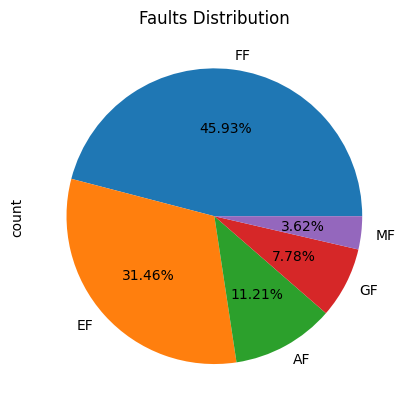

In [4]:
#======================================================= Parâmetros dos experimentos============================================================================
filename = "df_combine.csv"
path = os.path.join(os.getcwd(), 'compilacoes/data_exp_prepare')
df_combine = pd.read_csv(os.path.join(path, filename), low_memory=False)
df_combine.Fault.value_counts()
fault= [['AF', ]]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
savefig = False # Salvar Figuras
random_state = 80
numbers_features = 8 # Numeros de Features para serem selecionadas
batch_size = 400 # Tamanho dos batchs para treino
qLayers = 1  # Número de camadas do circuito quântico
perc_F_NF = 0.40  # Relação de falha com não falha
res_C = []
res_Q  = []
result_kernel = []
i = 0
#=================================================================================================================================================================

print(df_combine.shape)
df_nf_ = df_combine[df_combine.Fault=='NF']
df_f = df_combine[df_combine.Fault !='NF']

num_NF = (df_f['Fault'].value_counts()[fault[i]] - perc_F_NF*df_f['Fault'].value_counts()[fault[i]])/perc_F_NF
num_NF = int(round(num_NF, 0))

df_nf = df_combine[df_combine.Fault=='NF'].sample(num_NF, replace=True ,random_state=random_state) # SELECIONANDO 300 SAMPLES DE CASOS DE NÃO FALHA
df_combine = pd.concat((df_nf, df_f), axis=0).reset_index(drop=True)

df = df_combine.drop(columns=['DateTime_x', 'Time', 'Error', 'WEC: ava. windspeed', 
                                    'WEC: ava. available P from wind',
                                    'WEC: ava. available P technical reasons',
                                    'WEC: ava. Available P force majeure reasons',
                                    'WEC: ava. Available P force external reasons',
                                    'WEC: max. windspeed', 'WEC: min. windspeed', 
                                    'WEC: Operating Hours', 
                                    'WEC: Production minutes', 'DateTime_y'])


#df= df[(df['Fault'] == 'NF') | (df['Fault'] == fault[0][0])| (df['Fault'] == fault[0][1])| (df['Fault'] == fault[0][2])| (df['Fault'] == fault[0][3])| (df['Fault'] == fault[0][4])]
df= df[(df['Fault'] == 'NF') | (df['Fault'] == fault[0][0])]
df_f.Fault.value_counts().plot.pie(autopct = '%.2f%%', title = 'Faults Distribution')

In [5]:
# QNN
df = df.sample(len(df))
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
le = LabelEncoder()
y = le.fit_transform(y)

for i in range(len(y)):
    if y[i] == 0:
        y[i] = 1
    elif y[i] == 1:
        y[i] = -1
        
        
df_combine.Fault.value_counts()


Fault
FF    254
EF    174
NF     93
AF     62
GF     43
MF     20
Name: count, dtype: int64

In [6]:
#QSVC
#df = df.sample(len(df))
#X = df.iloc[:,:-1]
#y = df.iloc[:,-1]
#le = LabelEncoder()
#y = le.fit_transform(y)

#for i in range(len(y)):
#    if y[i] == 0:
#        y[i] = 1
#    elif y[i] == 1:
#        y[i] = 0
        
        
df_combine.Fault.value_counts()

Fault
FF    254
EF    174
NF     93
AF     62
GF     43
MF     20
Name: count, dtype: int64

In [7]:
X_RFE = feature_selectionRFE(max_iter=500,data = df, X=X, y=y, numbers_features=numbers_features)
X = X_RFE[0] # Redução de features
#X_Best = feature_selectionKBest(X=X, y=y, numbers_features=numbers_features)
#X =X_Best[0]

# Apply undersampling using RandomUnderSampler
#undersampler = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
#X, y = undersampler.fit_resample(X, y)
smote = smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)


test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state= random_state)

print("Quantidade de DADOS DE FALHA/NAOFALHA", df.Fault.value_counts())
print("\n")
print("Quantidade de DADOS TOTAL", df.Fault.shape[0])
print(f"Porcentagem de DADOS PARA TREINO {(1-test_size)*100}%")
print(f"Porcentagem de DADOS PARA TESTE {(test_size)*100}%")
print(f"FORMATO X_train: {X_train.shape}\nFORMATO X_test: {X_test.shape}\nFormato y_train: {y_train.shape}\nFormato y_test: {y_test.shape}")
# Update n_features
n_features = X.shape[1]

# Now use X_selected instead of X in your quantum circuit

#print("Quantidade de FEATURES:", n_features)


Quantidade de DADOS DE FALHA/NAOFALHA Fault
NF    93
AF    62
Name: count, dtype: int64


Quantidade de DADOS TOTAL 155
Porcentagem de DADOS PARA TREINO 80.0%
Porcentagem de DADOS PARA TESTE 20.0%
FORMATO X_train: (148, 8)
FORMATO X_test: (38, 8)
Formato y_train: (148,)
Formato y_test: (38,)


In [8]:
# Scalling
std = StandardScaler()
X_train_prep = pd.DataFrame(std.fit_transform(X_train))
X_test_prep = pd.DataFrame(std.fit_transform(X_test))

In [9]:
loaded_classifier = NeuralNetworkClassifier.load("DobQPM_QNN.model")
#loaded_classifier = QSVC.load("DobQPM_QSVC.model")

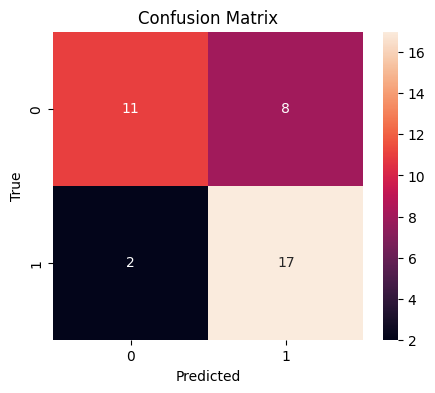

In [10]:
y_pred = loaded_classifier.predict(X_test_prep)
y_true = np.asarray(y_test)
average = 'micro'

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calcular acurácia
Acc = accuracy_score(y_true, y_pred)

# Mostrar métricas
pd.DataFrame({
    "Accuracy": round(Acc * 100, 3),
    "Precision": round(precision_score(y_true, y_pred, average=average) * 100, 3),
    "Recall": round(recall_score(y_true, y_pred, average=average) * 100, 3),
    "F1_Score": round(f1_score(y_true, y_pred, average=average) * 100, 3),
}, index=range(4)).head(1)

# Salvar resultado
with open("result.txt", "w") as f:
    f.write(f"QSVC Accuracy: {Acc * 100:.2f}%")
